In [44]:
from __future__ import division

import base64
import csv
import gzip
import zlib
import numpy as np
from tqdm import tqdm

from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt

In [45]:
TRACE_NUM = 1000
import logging
import importlib
importlib.reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)
        
def trace_worker(items_num, worker_id, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d in worker_id %d" % (items_num, worker_id))

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [47]:
from html.parser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()

def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [48]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [49]:
#html2text = html2text_bs
html2text = html2text_parser

#### Методы для токенизации текста

In [50]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("russian") 


def easy_tokenizer(text):
    word = str()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = str()
    if word: yield word

PYMORPHY_CACHE = {}
STEMMER_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]
        
def stemmer_list(lst):
    global STEMMER_CACHE
    stop_words = stopwords.words('russian')
    for word in lst:
        if word in stop_words:
            continue
        word_hash = hash(word)
        if word_hash not in STEMMER_CACHE:
            STEMMER_CACHE[word_hash] = stemmer.stem(word.lower())
        yield STEMMER_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [51]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

#### Рассчет финальных метрик

In [52]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print('threshold %s' % threshold)
            print('\tclass_prec %s, class_recall %s, class_F1 %s' % r[0])
            print('\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1])
            print('\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2))
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [112]:
banwords = [stemmer.stem(item) for item in
    ['секс', 'сиська', 'сиска', 'грудь', 'сосок', 'киска', 'анус', 'проститутка',
    'куртизанка', 'транс', 'порно', 'порнуха', 'порнушка', 'порево', 'скачать',
    'девственность', 'целка', 'инцест', 'голый', 'пизда', 'писька', 'писка', 'шлюха',
    'эротика', 'кунилингус', 'минет', 'лесбиянка', 'мастурбация', 'лезбеянка', 'страпон',
    'клитор', 'ебать', 'онлайн', 'мамаша', 'милфа', 'трахать', 'отсасывать', 'член', 'жесткий',
    'сосать', 'жопа', 'фетиш', 'онанизм', 'изнасилование', 'сучка', 'сука', 'кончить', 'сосочек',
    'шлендра', 'бикса', 'торрент', 'разврат', 'порноролик', 'порнофильм', 'лезбиянка', 'порнофото',
    'порнокартинка', 'насилие', 'ебля', 'регистрация', 'зарабатывать', 'заработок', 'эротический',
    'сексуальный', 'сисястый', 'анал', 'анальный', 'порнозвезда', 'минетчица', 'страпонить', 'ебаный',
    'хуй', 'пиздатый', 'хуевый', 'хуёвый', 'ёбаный', 'кончать', 'развратный', 'возбуждение', 'возбужденный',
    'ёбля', 'ебля', 'ёбырь', 'дрочка', 'дрочить', 'оргазм', 'сквирт', 'сквиртить', 'бдсм', 'буккаке', 'букаке',
    'проникновение', 'знакомство', 'знакомства', 'знакомиться', 'бесплатно', 'двойной', 'тройной', 'фистинг', 'бесплатный',
    'порносайт', 'малолетка', 'школьница', 'потерять', 'купить', 'смс']
]

In [113]:
from collections import Counter
import nltk
from bs4 import BeautifulSoup

In [114]:
from natasha import (
    Doc,
    Segmenter,
    NewsEmbedding,
    NewsMorphTagger,
    NewsNERTagger,
    NewsSyntaxParser,
    MorphVocab,
    NamesExtractor
)

In [115]:
emb = NewsEmbedding()
segmenter = Segmenter()
morph = MorphVocab()
ner_tagger = NewsNERTagger(emb)
morph_tagger = NewsMorphTagger(emb)

12:28:33 INFO:Loading dictionaries from C:\Users\NB\anaconda3\lib\site-packages\pymorphy2_dicts_ru\data
12:28:33 INFO:format: 2.4, revision: 417127, updated: 2020-10-11T15:05:51.070345


In [116]:
def calc_features(url, html_data):
    text = re.findall(r'[а-яА-ЯёЁ]{3,}', html_data)
    words = list(stemmer_list(text))
    
    doc = Doc(' '.join(text))
    doc.segment(segmenter)
    doc.tag_ner(ner_tagger)
    name_amount = len(doc.spans)
    
    soup = BeautifulSoup(html_data, 'lxml')

    bigrams = list(nltk.bigrams(words))
    words_len = len(words)
    ban_word_freq = sum(word in banwords for word in words) / words_len if words_len != 0 else 0
        
    pattern = lambda text: set(re.findall(r'(?:https?://(?:www.)?(.*)(?:\.ru|\.com|\.net|\.org|\.ms|\.de)?)?', text)[0].split('.'))
    hrefs = re.findall(r'href=[\'\"](.*?)[\'\"]', html_data)
    hrefs_len = len(hrefs)
    http_hrefs = re.findall(r'https?://(?:www.)?(.*?)\.(?:ru|com|net|org|ms|de)', ''.join(hrefs))

    self_ref = sum(not item.startswith('http') or len(pattern(url) & pattern(item)) != 0 for item in hrefs
                   if item is not None)
    away_ref_freq = 1 - self_ref / hrefs_len if hrefs_len != 0 else 1
    name_url_len = len(''.join(http_hrefs)) / len(http_hrefs) if len(http_hrefs) != 0 else 0
    
    avg_word_len = len(''.join(words)) / words_len if words_len != 0 else 0
    
    bold_tags = len(re.findall(r'<(b|strong|em|i|u|h[1-6])>', html_data))
    
    first_word_freq = Counter(words).most_common()[0][1] / words_len if words_len != 0 else 0
    second_word_freq = Counter(words).most_common()[1][1] / words_len if words_len > 2 else 0
    
    ban_bigrams = sum(item[0] in banwords and item[1] in banwords for item in bigrams)
    
    first_bigrams_freq = Counter(bigrams).most_common()[0][1] / len(bigrams) if len(bigrams) != 0 else 0
    
    return [words_len, ban_word_freq, away_ref_freq, hrefs_len, name_url_len, avg_word_len,
            bold_tags, first_word_freq, second_word_freq, ban_bigrams, first_bigrams_freq, name_amount]

In [117]:
test_html_data = u'''
<html>

<a href="https://olol.ru/penis"> порно в мире </a>
спам 1 2 3 Ирина хуй
</html>
'''
test_url = 'http://ololo'
test_features = calc_features(test_url, test_html_data)
print(test_features)

[5, 0.4, 1.0, 1, 4.0, 3.4, 0, 0.2, 0.2, 0, 0.25, 1]


In [118]:
logs = open('logs.txt', 'w')

In [119]:
from multiprocessing import Process, Queue

DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

WORKER_NUM = 4

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    global LAST_HTML
    with gzip.open(input_file_name, mode='rt', encoding='utf8') if input_file_name.endswith('gz') else open(input_file_name, mode='rt', encoding='utf8')  as input_file:            
        headers = input_file.readline()
        
        for i, line in tqdm(enumerate(input_file)):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            try:
                html_data = html_data.decode('utf8')
            except:
                html_data = html_data.decode('latin1')
            features = calc_features_f(url, html_data)            
            yield DocItem(url_id, mark, url, features)            
                
        trace(i, 1)  
        
def load_csv_worker(input_file_name, calc_features_f, worker_id, res_queue):    
    with gzip.open(input_file_name,  mode='rt', encoding='utf8') if input_file_name.endswith('gz') else open(input_file_name, mode='rt', encoding='utf8')  as input_file:            
        headers = input_file.readline()
        
        for i, line in tqdm(enumerate(input_file)):
            trace_worker(i, worker_id)
            if i % WORKER_NUM != worker_id: continue
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            try:
                html_data = html_data.decode('utf8')
            except:
                html_data = html_data.decode('latin1')
            features = calc_features_f(url, html_data)            
            res_queue.put(DocItem(url_id, mark, url, features))
                
        trace_worker(i, worker_id, 1)  
    res_queue.put(None)
        
def load_csv_multiprocess(input_file_name, calc_features_f):
    processes = []
    res_queue = Queue()    
    for i in range(WORKER_NUM):
        process = Process(target=load_csv_worker, args=(input_file_name, calc_features_f, i, res_queue))
        processes.append(process)
        process.start()
    
    complete_workers = 0
    while complete_workers != WORKER_NUM:
        item = res_queue.get()
        if item is None:
            complete_workers += 1
        else:
            yield item
        
    for process in processes: process.join()

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [120]:
%%time

TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv'
TEST_DATA_FILE  = 'kaggle_test_data_tab.csv'

train_docs = list(load_csv(TRAIN_DATA_FILE, calc_features))
test_docs = list(load_csv(TEST_DATA_FILE, calc_features))
# ololo = load_csv(TRAIN_DATA_FILE, calc_features)

0it [00:00, ?it/s]12:28:43 INFO:Complete items 00000
1000it [01:58, 15.79it/s]12:30:41 INFO:Complete items 01000
2000it [03:21, 11.29it/s]12:32:05 INFO:Complete items 02000
2998it [04:56,  4.37it/s]12:33:40 INFO:Complete items 03000
3999it [06:40,  8.17it/s]12:35:24 INFO:Complete items 04000
5000it [08:28, 12.75it/s]12:37:12 INFO:Complete items 05000
6000it [09:53, 18.45it/s]12:38:36 INFO:Complete items 06000
7000it [11:58,  9.03it/s]12:40:42 INFO:Complete items 07000
7044it [12:01,  9.76it/s]
12:40:45 INFO:Complete items 07043
0it [00:00, ?it/s]12:40:45 INFO:Complete items 00000
1000it [02:39, 13.05it/s]12:43:25 INFO:Complete items 01000
2000it [04:42, 12.27it/s]12:45:27 INFO:Complete items 02000
3000it [08:14,  5.80it/s]12:49:00 INFO:Complete items 03000
3999it [11:31,  5.00it/s]12:52:17 INFO:Complete items 04000
4998it [14:30, 11.34it/s]12:55:15 INFO:Complete items 05000
6000it [18:06,  7.93it/s]12:58:52 INFO:Complete items 06000
6999it [21:15,  7.08it/s]13:02:00 INFO:Complete items

Wall time: 1h 2min 13s


In [85]:
len(train_docs)

7044

In [22]:
len(test_docs)

16039

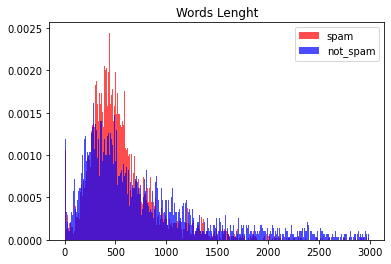

In [86]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('Words Lenght')
plt.legend()
plt.show()

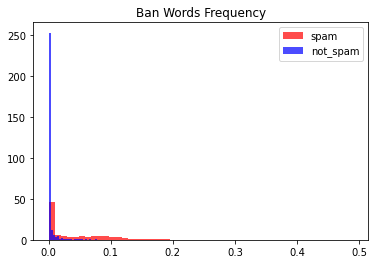

In [87]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = 50
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('Ban Words Frequency')
plt.legend()
plt.show()

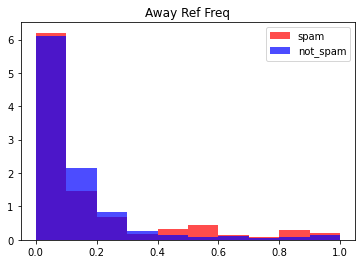

In [88]:
is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = 10
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('Away Ref Freq')
plt.legend()
plt.show()

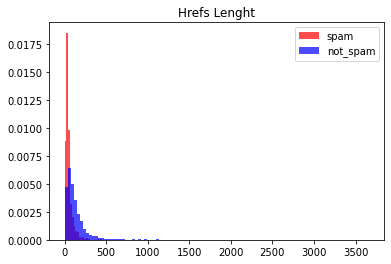

In [89]:
is_spam_data = [doc.features[3] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[3] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('Hrefs Lenght')
plt.legend()
plt.show()

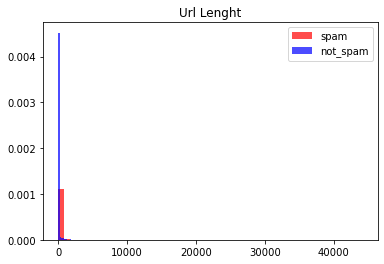

In [90]:
is_spam_data = [doc.features[4] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[4] for doc in train_docs if doc[1] == False]
bins = 50
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('Url Lenght')
plt.legend()
plt.show()

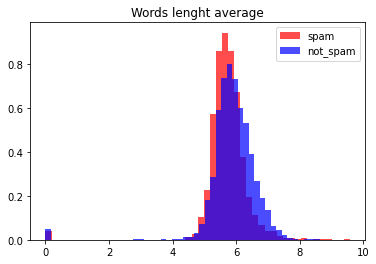

In [91]:
is_spam_data = [doc.features[5] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[5] for doc in train_docs if doc[1] == False]
bins = 50
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('Words lenght average')
plt.legend()
plt.show()

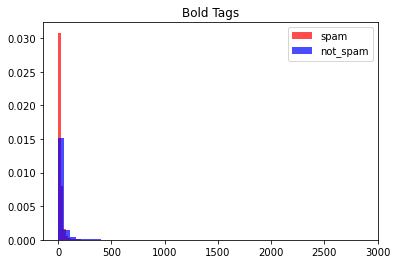

In [92]:
is_spam_data = [doc.features[6] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[6] for doc in train_docs if doc[1] == False]
bins = 50
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('Bold Tags')
plt.legend()
plt.show()

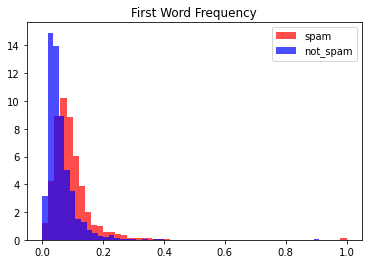

In [93]:
is_spam_data = [doc.features[7] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[7] for doc in train_docs if doc[1] == False]
bins = 50
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('First Word Frequency')
plt.legend()
plt.show()

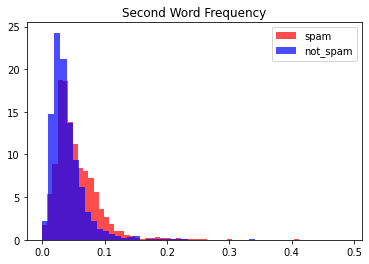

In [94]:
is_spam_data = [doc.features[8] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[8] for doc in train_docs if doc[1] == False]
bins = 50
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('Second Word Frequency')
plt.legend()
plt.show()

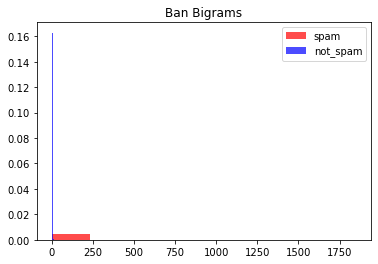

In [95]:
is_spam_data = [doc.features[9] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[9] for doc in train_docs if doc[1] == False]
bins = 8
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('Ban Bigrams')
plt.legend()
plt.show()

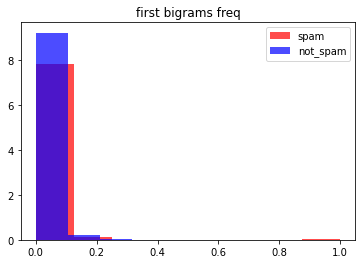

In [96]:
is_spam_data = [doc.features[10] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[10] for doc in train_docs if doc[1] == False]
bins = 8
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('first bigrams freq')
plt.legend()
plt.show()

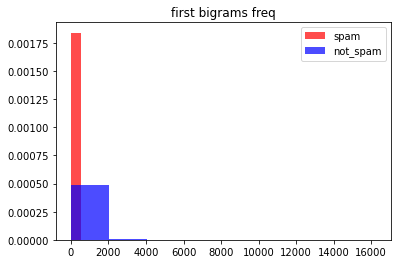

In [97]:
is_spam_data = [doc.features[11] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[11] for doc in train_docs if doc[1] == False]
bins = 8
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('first bigrams freq')
plt.legend()
plt.show()

In [98]:
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import xgboost

12:17:42 INFO:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
12:17:42 INFO:NumExpr defaulting to 8 threads.


In [99]:
X_data = np.array([item[3] for item in train_docs])
target = np.array([item[1] for item in train_docs]).astype(int)

In [43]:
X_test_data = np.array([item[3] for item in test_docs])

In [100]:
obj = StandardScaler()
X_scale = obj.fit_transform(X_data)

In [45]:
X_test_scale = obj.fit_transform(X_test_data)

In [107]:
clf = CatBoostClassifier(loss_function='Logloss',
                         verbose=True,
                         reg_lambda=0.01,
                         leaf_estimation_method='Gradient',
#                          custom_loss=['TotalF1:average=Weighted', 'Precision', 'Recall'],
                         iterations=100,
                         learning_rate=0.1,
                         depth=13)

In [108]:
cross_validate(clf, X_scale, target, cv=3)

0:	learn: 0.6748422	total: 167ms	remaining: 16.5s
1:	learn: 0.6579687	total: 347ms	remaining: 17s
2:	learn: 0.6407406	total: 529ms	remaining: 17.1s
3:	learn: 0.6232874	total: 711ms	remaining: 17.1s
4:	learn: 0.6077905	total: 898ms	remaining: 17.1s
5:	learn: 0.5923428	total: 1.08s	remaining: 17s
6:	learn: 0.5775883	total: 1.28s	remaining: 17s
7:	learn: 0.5648535	total: 1.49s	remaining: 17.1s
8:	learn: 0.5512650	total: 1.69s	remaining: 17.1s
9:	learn: 0.5386569	total: 1.88s	remaining: 16.9s
10:	learn: 0.5257293	total: 2.08s	remaining: 16.9s
11:	learn: 0.5142762	total: 2.27s	remaining: 16.7s
12:	learn: 0.5029221	total: 2.46s	remaining: 16.5s
13:	learn: 0.4920117	total: 2.66s	remaining: 16.3s
14:	learn: 0.4814327	total: 2.85s	remaining: 16.2s
15:	learn: 0.4717490	total: 3.04s	remaining: 16s
16:	learn: 0.4627353	total: 3.23s	remaining: 15.8s
17:	learn: 0.4546067	total: 3.42s	remaining: 15.6s
18:	learn: 0.4460312	total: 3.61s	remaining: 15.4s
19:	learn: 0.4370920	total: 3.8s	remaining: 15.2s

64:	learn: 0.2306593	total: 12.7s	remaining: 6.83s
65:	learn: 0.2283162	total: 12.9s	remaining: 6.63s
66:	learn: 0.2256984	total: 13.1s	remaining: 6.43s
67:	learn: 0.2234091	total: 13.3s	remaining: 6.24s
68:	learn: 0.2210838	total: 13.4s	remaining: 6.04s
69:	learn: 0.2188366	total: 13.6s	remaining: 5.84s
70:	learn: 0.2163495	total: 13.8s	remaining: 5.64s
71:	learn: 0.2141043	total: 14s	remaining: 5.45s
72:	learn: 0.2116914	total: 14.2s	remaining: 5.25s
73:	learn: 0.2095810	total: 14.4s	remaining: 5.07s
74:	learn: 0.2073132	total: 14.6s	remaining: 4.87s
75:	learn: 0.2054552	total: 14.8s	remaining: 4.68s
76:	learn: 0.2034499	total: 15s	remaining: 4.48s
77:	learn: 0.2015403	total: 15.2s	remaining: 4.28s
78:	learn: 0.1995860	total: 15.4s	remaining: 4.09s
79:	learn: 0.1975462	total: 15.6s	remaining: 3.9s
80:	learn: 0.1956671	total: 15.8s	remaining: 3.71s
81:	learn: 0.1937355	total: 16s	remaining: 3.51s
82:	learn: 0.1916752	total: 16.2s	remaining: 3.31s
83:	learn: 0.1900629	total: 16.4s	rema

{'fit_time': array([19.7009542 , 19.63415933, 19.40977645]),
 'score_time': array([0.00999856, 0.015558  , 0.        ]),
 'test_score': array([0.9390971 , 0.9241908 , 0.93568995])}

In [47]:
clf.fit(X_scale, target)

In [48]:
clf.feature_importances_

array([ 8.99244796, 10.90903959, 15.45510843, 15.65089935, 13.97669781,
        6.35885872,  9.10927618,  6.43199875,  3.43020216,  4.41074924,
        5.27472182])

In [49]:
kaggle = clf.predict(X_test_scale)

In [52]:
ids = [item[0] for item in test_docs]

In [53]:
df = pd.DataFrame({'Id': ids, 'Prediction': kaggle.reshape(-1)})
df.to_csv('result.csv', index=False)